# Intro

- package loading
- data loading
- data preprocessing

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from tqdm import tqdm

import seaborn as sns
import random

def plotsize(w, h):
    plt.figure(figsize=(w, h))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

np.random.seed(42)
torch.manual_seed(42)


In [677]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from src.process_data import IBMDataset
df = IBMDataset().ibm_credit_card()

In [5]:
df.head()

,customer.id,card.id,amount_signed,timestamp,date,merchant.name,merchant.city,merchant.state,is_fraud,age,chip,gender,customer.city,customer.state,score,num_cards,total_debt,credit_limit,card.brand,latitude,longitude,direction,amount_usd,log_amount
0,0,4344676511950444,134.09,1030861260,2002-09-01 06:21:00,3527213246127876953,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,134.09,4.905941
1,0,4344676511950444,38.48,1030862520,2002-09-01 06:42:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,38.48,3.675794
2,0,4344676511950444,120.34,1030947720,2002-09-02 06:22:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,120.34,4.798597
3,0,4344676511950444,128.95,1030988700,2002-09-02 17:45:00,3414527459579106770,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,128.95,4.867150
4,0,4344676511950444,104.71,1031034180,2002-09-03 06:23:00,5817218446178736267,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,104.71,4.660699


In [6]:
df.is_fraud.value_counts()

is_fraud
No     24357143
Yes       29757
Name: count, dtype: int64

In [7]:
df['merchant.state'].nunique()

223

In [8]:
df['customer.state'].nunique()

51

In [9]:
df[['merchant.state', 'is_fraud']].value_counts()

merchant.state  is_fraud
CA              No          2591079
TX              No          1792993
FL              No          1458385
NY              No          1446624
OH              No           895092
                             ...   
Tonga           No                2
Togo            No                2
Paraguay        No                1
Botswana        No                1
Kiribati        No                1
Name: count, Length: 282, dtype: int64

## Feature engineering

Fixed numerical features:
- amount features: amount, yearly income, total debt, credit limit (in log scale)
- num credit cards
- FICO score

Time features:
- time from last transaction
- time of transaction
- mean time between previous transactions

Categorical features:
- gender
- card brand
- card type
- chip

Binary features:
- previously seen merchant ID
- has chip (card)
- state == merchant state

In [6]:
df.sort_values('date', inplace=True)

In [7]:
gdf = df.groupby('customer.id')

In [24]:
new_groups = []

for name, group in tqdm(gdf):
    # figure out known merchants
    known_merchants = group['merchant.name'].duplicated().astype(int)
    
    # create a copy of the group
    g_new = group.copy()
    g_new['is_known_merchant'] = known_merchants
    
    # time difference for the customer
    # g_new['log_timediff'] = np.log(1 + g_new['date'].diff().dt.seconds.fillna(0, inplace=True))
    g_new['log_timediff'] = np.log(1 + g_new['date'].diff().dt.seconds).fillna(0)
    
    # customer address and merchant address
    g_new['same_city'] = (group['merchant.city'] == group['customer.city'])
    g_new['same_state'] = (group['merchant.state'] == group['customer.state'])
    
    new_groups.append(g_new)


100%|██████████| 2000/2000 [00:17<00:00, 111.20it/s]


In [25]:
g = new_groups[0]
g

,customer.id,card.id,amount_signed,timestamp,date,merchant.name,merchant.city,merchant.state,is_fraud,age,chip,gender,customer.city,customer.state,score,num_cards,total_debt,credit_limit,card.brand,latitude,longitude,direction,amount_usd,log_amount,is_known_merchant,log_timediff,same_city,same_state
0,0,4344676511950444,134.09,1030861260,2002-09-01 06:21:00,3527213246127876953,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,134.09,4.905941,0,0.000000,True,True
1,0,4344676511950444,38.48,1030862520,2002-09-01 06:42:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,38.48,3.675794,0,7.139660,False,True
2,0,4344676511950444,120.34,1030947720,2002-09-02 06:22:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,120.34,4.798597,1,11.352768,False,True
3,0,4344676511950444,128.95,1030988700,2002-09-02 17:45:00,3414527459579106770,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,128.95,4.867150,0,10.620864,False,True
4,0,4344676511950444,104.71,1031034180,2002-09-03 06:23:00,5817218446178736267,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,104.71,4.660699,0,10.725050,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19934,0,4879494103069057,-295.00,1582816920,2020-02-27 15:22:00,7834055923142137930,New York,NY,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,12400.0,Visa,34.15,-117.76,inbound,295.00,5.690359,1,5.707110,False,False
10544,0,4582313478255491,46.77,1582870980,2020-02-28 06:23:00,-727612092139916043,Monterey Park,CA,No,53,Chip Transaction,Female,La Verne,CA,787,5,127613.0,46414.0,Visa,34.15,-117.76,outbound,46.77,3.866398,1,10.897868,False,True
19935,0,4879494103069057,114.51,1582871340,2020-02-28 06:29:00,-34551508091458520,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,12400.0,Visa,34.15,-117.76,outbound,114.51,4.749357,1,5.888878,True,True
19936,0,4879494103069057,34.11,1582872780,2020-02-28 06:53:00,-34551508091458520,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,12400.0,Visa,34.15,-117.76,outbound,34.11,3.558486,1,7.273093,True,True


In [10]:
g['card.brand'].value_counts()

card.brand
Visa          19937
Mastercard       26
Name: count, dtype: int64

In [26]:
data = pd.concat(objs=new_groups)

In [27]:
data['merchant.state'].fillna('None', inplace=True)

In [28]:
data['merchant.state'].isna().mean()

0.0

In [29]:
len(data[data['is_fraud'] == 'Yes'])

29757

In [30]:
data['merchant.state'].value_counts()

merchant.state
None        2720821
CA          2591830
TX          1793298
FL          1458699
NY          1446864
             ...   
Tonga             2
Togo              2
Kiribati          1
Paraguay          1
Botswana          1
Name: count, Length: 224, dtype: int64

In [906]:
def convert_time_features(df, datetime_column_name = 'datetime'):
    """
	Converts `datetime_column_name` from DataFrame to 2D sin/cos encoded
	numerical features. Encodes
	- day of the week
	- day of the month
	- month of the year
    - hour of day
    - minute of hour

	:returns
	- np.array of shape (nrows, 10)
	"""

    # Convert the date column to datetime objects
    dates = pd.to_datetime(df[datetime_column_name])

    # Calculate the angles for each time feature
    day_of_week_angle = 2 * np.pi * dates.dt.dayofweek / 7
    day_of_month_angle = 2 * np.pi * (dates.dt.day - 1) / (dates.dt.daysinmonth - 1)
    month_angle = 2 * np.pi * (dates.dt.month - 1) / 12
    hour_angle = 2 * np.pi * (dates.dt.hour - 1) / 24
    minute_angle = 2 * np.pi * (dates.dt.minute - 1) / 60

    # Transform the angles into continuous features using sine and cosine functions
    day_of_week = np.column_stack((np.sin(day_of_week_angle), np.cos(day_of_week_angle)))
    day_of_month = np.column_stack((np.sin(day_of_month_angle), np.cos(day_of_month_angle)))
    month = np.column_stack((np.sin(month_angle), np.cos(month_angle)))
    hour = np.column_stack((np.sin(hour_angle), np.cos(hour_angle)))
    minute = np.column_stack((np.sin(minute_angle), np.cos(minute_angle)))

    # Combine the continuous features into a single numpy array
    time_features = np.hstack((day_of_week, day_of_month, month, hour, minute))

    return time_features

In [907]:
data.head()

,customer.id,card.id,amount_signed,timestamp,date,merchant.name,merchant.city,merchant.state,is_fraud,age,chip,gender,customer.city,customer.state,score,num_cards,total_debt,credit_limit,card.brand,latitude,longitude,direction,amount_usd,log_amount,is_known_merchant,log_timediff,same_city,same_state
0,0,4344676511950444,134.09,1030861260,2002-09-01 06:21:00,3527213246127876953,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,134.09,4.905941,0,0.000000,True,True
1,0,4344676511950444,38.48,1030862520,2002-09-01 06:42:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,38.48,3.675794,0,7.139660,False,True
2,0,4344676511950444,120.34,1030947720,2002-09-02 06:22:00,-727612092139916043,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,120.34,4.798597,1,11.352768,False,True
3,0,4344676511950444,128.95,1030988700,2002-09-02 17:45:00,3414527459579106770,Monterey Park,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,128.95,4.867150,0,10.620864,False,True
4,0,4344676511950444,104.71,1031034180,2002-09-03 06:23:00,5817218446178736267,La Verne,CA,No,53,Swipe Transaction,Female,La Verne,CA,787,5,127613.0,24295.0,Visa,34.15,-117.76,outbound,104.71,4.660699,0,10.725050,True,True


In [908]:
data.date.dt

In [909]:
tmp = convert_time_features(data, 'date')

In [910]:
tmp.shape

(24386900, 10)

In [911]:
from sklearn.preprocessing import OneHotEncoder

oh_customer_state = OneHotEncoder(min_frequency=1, sparse_output=False)
oh_merchant_state = OneHotEncoder(min_frequency=5, sparse_output=False)

oh_customer_state.fit(np.array(data['customer.state']).reshape(-1,1))
oh_merchant_state.fit(np.array(data['merchant.state']).reshape(-1,1))

OneHotEncoder(min_frequency=5, sparse_output=False)

In [912]:
class TransactionDataset(Dataset):
    def __init__(self, gdf, oh_c, oh_m, seq_length):
        self.gdf = gdf
        self.len = len(gdf)
        self.groups = list(gdf.groups)
        self.oh_customer_state = oh_c
        self.oh_merchant_state = oh_m
        self.seq_length = seq_length

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        g = self.get_group(idx)
        data, label = self.process_rows(g)
        return data, label
    
    def get_group_by_label(self, group_ix, transaction_ix):
        g = self.gdf.get_group(group_ix)

        loc_idx = g.index.get_loc(transaction_ix)

        start_ix = loc_idx - self.seq_length + 1
        if start_ix < 0:
            return None
        
        g = g.iloc[start_ix:loc_idx+1]
        return self.process_rows(g)
        
    
    def get_group(self, idx):
        # get the group
        g = self.gdf.get_group(self.groups[idx])

        # get the sequence length of customers transactions
        l = len(g)
        start_ix = random.sample(range(l - self.seq_length), 1)[0] + 1
        g = g.iloc[start_ix:start_ix + self.seq_length]
        return g
    
    def get_group_all_sequences(self, idx):
        # get the group
        g = self.gdf.get_group(self.groups[idx])

        # process values and labels
        processed, _ = self.process_rows(g)
        labels = np.array(g['is_fraud'] == 'Yes', dtype=float)

        max_len = processed.shape[0]
        sequences = [processed[start_ix:start_ix+self.seq_length] for start_ix in range(max_len - self.seq_length + 1)]
        sequences = np.stack(sequences, axis=0)
        labels = np.hstack([labels[start_ix + self.seq_length - 1] for start_ix in range(max_len - self.seq_length + 1)])
        
        return sequences, labels

    
    def process_rows(self, g):
        # process the data
        direction = np.array(g['direction'] == 'inbound', dtype=float)
        brand = np.array(g['card.brand'] == 'Visa', dtype=float)
        gender = np.array(g['gender'] == 'female', dtype=float)
        same_city = np.array(g['same_city'], dtype=float)
        same_state = np.array(g['same_state'], dtype=float)
        known_merchant = np.array(g['is_known_merchant'], dtype=float)
        debt = np.array(np.log(1 + g['total_debt']), dtype=float)
        limit = np.array(np.log(1 + g['credit_limit']), dtype=float)
        
        customer_state = self.oh_customer_state.transform(np.array(g['customer.state']).reshape(-1,1))
        merchant_state = self.oh_merchant_state.transform(np.array(g['merchant.state']).reshape(-1,1))

        Fnum = np.array(g[['age', 'num_cards', 'log_amount', 'log_timediff', 'latitude', 'longitude']], dtype=float)
        if len(Fnum.shape) == 1:
            Fnum = Fnum.reshape(-1,1).transpose()
            
        Fcat = np.vstack((debt, limit, direction, brand, gender, same_city, same_state, known_merchant)).transpose()
        Fdatetime = convert_time_features(g, 'date')

        F = np.hstack((customer_state, merchant_state, Fnum, Fcat, Fdatetime))

        # get the label of the last transaction in the sequence
        label = np.array(g.iloc[-1]['is_fraud'] == 'Yes', dtype=float)

        return np.array(F, dtype=float), label

Here, we need to create a train / validation / test split. The goal is to split by customers (or by cards, but generally customers), because we need to flag based on customer's behavior.

In the notebook `classifier.ipynb`, there is a point-wise detection, which is quite bad.

Here, we want to do detection based on RNNs and sequences of transactions. For us to be able to do that, we need to prepare the data and create the sequences on the go. So, let's dive in.

In [469]:
# Split indexes by customers

from sklearn.model_selection import train_test_split

grouped_df = data.groupby('customer.id')
groups = np.array(list(grouped_df.groups))

index_list = list(range(len(groups)))
tmp, _test_ix = train_test_split(index_list, test_size=0.2, random_state=31)
_train_ix, _val_ix = train_test_split(tmp, test_size=0.3, random_state=31)

print(len(_train_ix))
print(len(_val_ix))
print(len(_test_ix))

train_ix = []
val_ix = []
test_ix = []

for gix in groups[_train_ix]:
    g = grouped_df.get_group(gix)
    indexes = g.index
    train_ix.extend(indexes)

for gix in groups[_val_ix]:
    g = grouped_df.get_group(gix)
    indexes = g.index
    val_ix.extend(indexes)

for gix in groups[_test_ix]:
    g = grouped_df.get_group(gix)
    indexes = g.index
    test_ix.extend(indexes)

1120
480
400


In [481]:
train_data = data.loc[train_ix]
val_data = data.loc[val_ix]
test_data = data.loc[test_ix]

In [913]:
train_dataset = TransactionDataset(train_data.groupby('customer.id'), oh_customer_state, oh_merchant_state, 10)
val_dataset = TransactionDataset(val_data.groupby('customer.id'), oh_customer_state, oh_merchant_state, 10)
test_dataset = TransactionDataset(test_data.groupby('customer.id'), oh_customer_state, oh_merchant_state, 10)

In [914]:
d, l = train_dataset[1]
d.shape

(10, 289)

In [915]:
x, y = train_dataset.get_group_all_sequences(0)

In [916]:
print(x.shape)
print(y.shape)
print(np.sum(y))

(19954, 10, 289)
(19954,)
27.0


In [942]:
def get_predictions(model, dataset, break_at=100):
    model.eval()
    ytrue = []
    yhat = []
    tmp = 0
    for i in tqdm(range(len(dataset))):
        x, y = dataset.get_group_all_sequences(i)
        with torch.no_grad():
            yh = model(torch.tensor(x, dtype=torch.float32))
            ytrue.extend(y)
            yhat.extend(yh.detach().numpy())
            tmp += 1
            if tmp > break_at:
                break

    return ytrue, yhat

In [740]:
def calculate_accuracy_and_f1(model, dataset, break_at=100, return_values=False) -> tuple:
    """
    Calculates accuracy and F1 score for specified number of samples in `dataset`.

    returns: f1, acc
    """
    model.eval()
    ytrue = []
    yhat = []
    tmp = 0
    for i in tqdm(range(len(dataset))):
        x, y = dataset.get_group_all_sequences(i)
        with torch.no_grad():
            yh = model(torch.tensor(x, dtype=torch.float32))
            ytrue.extend(y)
            yhat.extend(yh.detach().numpy())
            tmp += 1
            if tmp > break_at:
                break

    f1 = f1_score(ytrue, np.round(yhat))
    acc = accuracy_score(ytrue, np.round(yhat))
    print('-'* 40)
    print('Scores')
    print('   - F1 score:', round(f1, 4))
    print('   - Accuracy:', round(acc, 4))
    print('-'* 40)
    if return_values:
        return f1, acc

Now, we need the CustomDataset class and CustomUpsampleDataset class to get the samples for training of the RNN model.

In [473]:
pos_idx = {}
neg_idx = {}
for cid, group in train_data.groupby('customer.id'):
    p = group[group['is_fraud'] == 'Yes'].index
    n = group[group['is_fraud'] == 'No'].index

    if len(p) > 0:
        pos_idx[cid] = p
    if len(n) > 0:
        neg_idx[cid] = n

In [760]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y
    
class CustomUpsampleDataset(Dataset):
    def __init__(self, dataset, pidx, nidx, length):
        self.dataset = dataset
        self.positive_idx = pidx
        self.negative_idx = nidx
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        while True:
            if random.random() > 0.5:
                idx = random.sample(list(self.positive_idx.keys()), 1)[0]
                i = random.sample(list(self.positive_idx[idx]), 1)[0]
                t = self.dataset.get_group_by_label(idx, i)
            else:
                idx = random.sample(list(self.negative_idx.keys()), 1)[0]
                i = random.sample(list(self.negative_idx[idx]), 1)[0]
                t = self.dataset.get_group_by_label(idx, i)
            
            if t is not None:
                x, y = t
        
                x = torch.tensor(x, dtype=torch.float32).squeeze(0)
                y = torch.tensor(y, dtype=torch.float32)
                return x, y

    @property    
    def len(self):
        return len(self.dataset)

In [918]:
tmp = CustomUpsampleDataset(train_dataset, pos_idx, neg_idx, length=1_000)
train_loader = DataLoader(tmp, batch_size=32)

for batch in train_loader:
    x, y = batch
    break

print('Shape of the batch:', x.shape)
y

Shape of the batch: torch.Size([32, 10, 289])


tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.])

## PyTorch model

Create a RNN model that should predict if the last transaction in the sequence is fraudulent or not.

In [919]:
import torch.nn as nn

class FraudDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional):
        super(FraudDetector, self).__init__()
        self.pre_net = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(
            hidden_size, hidden_size, num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.mult = 2 if bidirectional else 1
        self.post_net = nn.Linear(hidden_size * self.mult, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pre_net(x)
        out, (h, c) = self.lstm(x)
        out = self.post_net(out)

        # return the last value for prediction
        return self.sigmoid(out[:, -1, 0])

In [920]:
detector = FraudDetector(289, 64, 1, 3, True)

In [921]:
yhat = detector(x)

In [922]:
x.shape

torch.Size([32, 10, 289])

In [923]:
train_dataset[0][0].shape[-1]

289

In [924]:
# Hyperparameters

input_size = train_dataset[0][0].shape[-1]
hidden_size = 256
num_layers = 3
bidirectional = False
output_size = 1
learning_rate = 0.001

batch_size = 64

In [925]:
# Model, loss, optimizer

model = FraudDetector(input_size, hidden_size, output_size, num_layers, bidirectional)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device('cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model

FraudDetector(
  (pre_net): Linear(in_features=289, out_features=256, bias=True)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True)
  (post_net): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [926]:
# DataLoaders

tmp1 = CustomUpsampleDataset(train_dataset, pos_idx, neg_idx, length=10_000)
train_upsample_loader = DataLoader(tmp1, batch_size=batch_size, shuffle=True)

tmp11 = CustomDataset(train_dataset)
train_loader = DataLoader(tmp11, batch_size=batch_size, shuffle=False)

tmp2 = CustomDataset(val_dataset)
val_loader = DataLoader(tmp2, batch_size=batch_size, shuffle=False)

tmp3 = CustomDataset(test_dataset)
test_loader = DataLoader(tmp3, batch_size=batch_size, shuffle=False)

In [927]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 10, 289])
torch.Size([64])


In [972]:
bce = nn.BCELoss(reduction='none')

def loss_fn(x, y, ratio=100):
    ind_losses = bce(x, y)
    scaled_losses = ind_losses * (y * (ratio - 1) + 1) / 100
    return torch.mean(scaled_losses)

In [929]:
criterion(model(x), y)

tensor(0.6845, grad_fn=<BinaryCrossEntropyBackward0>)

In [930]:
loss_fn(model(x), y)

tensor(0.0178, grad_fn=<MeanBackward0>)

In [939]:
max_validation_f1 = [0]
train_losses = []
train_accuracies = []

In [973]:
# Define the training loop
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, max_validation_f1, train_losses, train_accuracies, ratio=100):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_total = 0
        train_correct = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs, labels.float())
            loss = loss_fn(outputs, labels, ratio=ratio)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            train_total += labels.size(0)
            train_correct += ((outputs >= 0.5).squeeze().long() == labels).sum().item()
        
        train_loss /= train_total
        train_accuracy = train_correct / train_total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # # Print training and validation metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        # print(f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
        # print()

        # Get validation scores
        if (epoch + 1) % 10 == 1 and epoch > 10:
            f1, acc = calculate_accuracy_and_f1(model, val_dataset, break_at=20, return_values=True)
            if f1 > max(max_validation_f1):
                max_validation_f1.append(f1)


In [980]:
train(
    model, criterion, optimizer,
    train_upsample_loader, val_loader, 20,
    max_validation_f1, train_losses, train_accuracies,
    ratio=500
)

Epoch 1/20
Train Loss: 0.0195 - Train Accuracy: 0.6520
Epoch 2/20
Train Loss: 0.0199 - Train Accuracy: 0.5951
Epoch 3/20
Train Loss: 0.0213 - Train Accuracy: 0.5840
Epoch 4/20
Train Loss: 0.0232 - Train Accuracy: 0.5844
Epoch 5/20
Train Loss: 0.0241 - Train Accuracy: 0.5457
Epoch 6/20
Train Loss: 0.0224 - Train Accuracy: 0.5437
Epoch 7/20
Train Loss: 0.0213 - Train Accuracy: 0.5806
Epoch 8/20
Train Loss: 0.0194 - Train Accuracy: 0.6173
Epoch 9/20
Train Loss: 0.0230 - Train Accuracy: 0.5445
Epoch 10/20
Train Loss: 0.0207 - Train Accuracy: 0.5592
Epoch 11/20
Train Loss: 0.0216 - Train Accuracy: 0.5603
Epoch 12/20
Train Loss: 0.0210 - Train Accuracy: 0.5698
Epoch 13/20
Train Loss: 0.0226 - Train Accuracy: 0.5835
Epoch 14/20
Train Loss: 0.0202 - Train Accuracy: 0.5856
Epoch 15/20
Train Loss: 0.0231 - Train Accuracy: 0.5448
Epoch 16/20
Train Loss: 0.0215 - Train Accuracy: 0.5645
Epoch 17/20
Train Loss: 0.0222 - Train Accuracy: 0.5652
Epoch 18/20
Train Loss: 0.0221 - Train Accuracy: 0.5837
E

In [944]:
max_validation_f1

[0,
 0.003335933281334373,
 0.0035777024200969064,
 0.003714864133521304,
 0.003956563198269359]

In [903]:
calculate_accuracy_and_f1(model, train_dataset, break_at=100)

  9%|▉         | 100/1120 [01:49<18:39,  1.10s/it]


----------------------------------------
Scores
   - F1 score: 0.0033
   - Accuracy: 0.3138
----------------------------------------


In [905]:
calculate_accuracy_and_f1(model, val_dataset, break_at=10)

  2%|▏         | 10/480 [00:14<11:32,  1.47s/it]

----------------------------------------
Scores
   - F1 score: 0.0023
   - Accuracy: 0.4068
----------------------------------------


In [771]:
# Check if the labels are really 50% in ratio
# Think about predicting whether a sequence has a fraud or not?
# Predicting the full label vector for those?

In [981]:
ytrue, yhat = get_predictions(model, train_dataset, break_at=100)

  9%|▉         | 100/1120 [01:46<18:02,  1.06s/it]


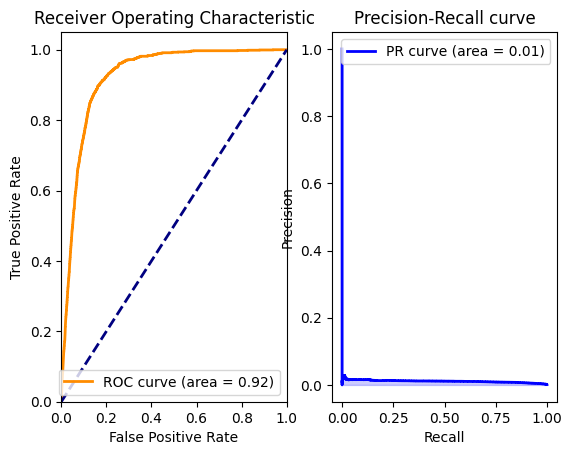

Threshold value is: 0.9998233


In [982]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc

# ROC curve
fpr, tpr, thresholds = roc_curve(ytrue, yhat)
roc_auc = auc(fpr, tpr) # compute Area Under the Curve

plt.subplot(1,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR curve
precision, recall, thresholds = precision_recall_curve(ytrue, yhat)
pr_auc = auc(recall, precision) # compute Area Under the Curve

# plt.figure()
plt.subplot(1,2,2)
plt.plot(recall, precision, color='b', lw=lw, label='PR curve (area = %0.2f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

# find the optimal threshold for F1 score
b = precision + recall
precision = precision[b != 0]
recall = recall[b != 0]
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


In [983]:
def color_confusion_matrix(val):
    if 'TN' in val or 'TP' in val:
        color = 'green'
    else:
        color = 'red'
    return 'color: %s' % color

In [984]:
from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(ytrue, np.array(yhat) > 0.99)
cm = confusion_matrix(ytrue, np.array(yhat) > optimal_threshold)

cm_labeled = pd.DataFrame({
    'Predicted Negative': {'Actual Negative': f'TN: {cm[0,0]}', 'Actual Positive': f'FN: {cm[1,0]}'},
    'Predicted Positive': {'Actual Negative': f'FP: {cm[0,1]}', 'Actual Positive': f'TP: {cm[1,1]}'},
})

cm_labeled = cm_labeled.style.applymap(color_confusion_matrix)
display(cm_labeled)

,Predicted Negative,Predicted Positive
Actual Negative,TN: 1212368,FP: 10986
Actual Positive,FN: 1221,TP: 177


In [985]:
pr = cm[1,1] / (cm[1,1] + cm[0,1])
rc = cm[1,1] / (cm[1,0] + cm[1,1])
f1 = 2 * pr * rc / (pr + rc)
acc = (cm[0,0] + cm[1,1]) / np.sum(cm)
print(f"F1 score: {round(f1, 4)}")
print(f"Accuracy: {round(acc, 4)}")

F1 score: 0.0282
Accuracy: 0.99
